# Building a Chatbot from Scratch 

##### In this project we will build a chatbot from scratch using the corenell University's Movie Dialogue corpus.
##### We will be using a deep learning based architecture with the main components as a lstm based encoder and decoder.

In [1]:
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from collections import Counter
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
import keras
import nltk
import numpy
import sklearn

Please make sure that the version of the respective packages are met to the requirement

In [0]:
# assert keras.__version__=='2.1.2'
# assert nltk.__version__=='3.4.1'
# assert sklearn.__version__=='0.21.2'
# assert numpy.__version__=='1.12.1'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Download the glove model available at https://nlp.stanford.edu/projects/glove/

Specification : Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip


you can download it with 'wget' or can directly put the embedding zip file inside 'embedding_data' folder and unzip it.

In [0]:
# ! curl -O http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip 

In [0]:
RAND_STATE=np.random.seed(42)
BATCH_SIZE = 64
NUM_EPOCHS = 50
GLOVE_EMBEDDING_SIZE = 100
HIDDEN_UNITS = 256
MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
MAX_VOCAB_SIZE = 10000
DATA_SET_NAME = 'cornell'
DATA_PATH = '/content/gdrive/My Drive/Conversational Chatbot/movie_lines_cleaned.txt'
GLOVE_MODEL = '/content/gdrive/My Drive/Conversational Chatbot/glove.twitter.27B.100d.txt'
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
WEIGHT_FILE_PATH =  '/content/gdrive/My Drive/Conversational Chatbot/word-glove-weights.h5'

In [6]:
def in_white_list(_word):
  notwhitelist = []
  '''Check if the characters in the words are whitelisted'''
  for char in _word:
        if char in WHITELIST:
            return True

  return False

print("Some characters are not in whitelist")
in_white_list(DATA_PATH)

Some characters are not in whitelist


True

Load the glove word embedding in to a dictionary where the **key** is a unique **word token** and the **value** is a **d** dimension vector 

# Test-1

In [0]:
def load_glove_vector():
    _word2embedding = {}
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    for line in file:
        '''write here. write your code to load the data in to the dictionary
        make sure the value is a numpy array of size 100
        max  3 to 6 lines of code'''
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        _word2embedding[word] = vector
        # print(line)
    file.close()
    return _word2embedding

In [0]:
word2embedding = load_glove_vector()

# Check-1

In [9]:
assert len(word2embedding.keys())==1193514
for key in word2embedding.keys():
    try:
        assert len(word2embedding[key])==100
    except AssertionError:
        print (key,len(word2embedding[key]))     

-0.32053 99


# Data Preparation

In [0]:
target_counter = Counter()
lines = open(DATA_PATH, 'rt', encoding='utf8').read().split('\n')
input_texts = []
target_texts = []
prev_words = []

In [0]:
for line in lines:
    next_words = [w.lower() for w in nltk.word_tokenize(line)]
    if len(next_words) > MAX_TARGET_SEQ_LENGTH:
        next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]
    if len(prev_words) > 0:
        input_texts.append(prev_words)
        target_words = next_words[:]
        target_words.insert(0, 'start')
        target_words.append('end')
        for w in target_words:
            target_counter[w] += 1
        target_texts.append(target_words)
    prev_words = next_words

Filter the conversations till max word length and convert the dialogues pairs into input text and target texts. Put **start** and **end** token to recognise the beginning and end of the sentence token.

## Let's see some of the training examples

In [12]:
for idx, (input_words, target_words) in enumerate(zip(input_texts, target_texts)):
    if idx > 10:
        break
    print([input_words, target_words])

[['they', 'do', 'not', '!'], ['start', 'they', 'do', 'to', '!', 'end']]
[['they', 'do', 'to', '!'], ['start', 'i', 'hope', 'so', '.', 'end']]
[['i', 'hope', 'so', '.'], ['start', 'she', 'okay', '?', 'end']]
[['she', 'okay', '?'], ['start', 'let', "'s", 'go', '.', 'end']]
[['let', "'s", 'go', '.'], ['start', 'wow', 'end']]
[['wow'], ['start', 'okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.', 'end']]
[['okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.'], ['start', 'no', 'end']]
[['no'], ['start', 'i', "'m", 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''", '?', 'and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit', '?', 'end']]
[['i', "'m", 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''", '?', 'and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit', '?'], ['start', 'like', 'my', 'fear', 'of', 'wearin

### Create two dictionaries 
<ol>
<li>target_word2id
<li>target_id2word
</ol>
and save it as NumPy file format in the disk.
<p>
<strong>NOTE:</strong> The ids should start from 1 beacause <strong>0</strong> is reserved for <strong>'unknown'</strong> tokens.
Make sure you cosider only the <strong>most common</strong> tokens with <strong>MAX_VOCAB_SIZE</strong> defined above.

Most common refers to tokens with higher frequency. 
</p>
<strong>Help:</strong>
<ol>
<li>Use the target_counter which have the token counts.  
<li>Use target_counter.most_common(MAX_VOCAB_SIZE) to filter common tokens
    </ol>

In [0]:
target_word2idx = dict()
'''create a target word to id dictionary called target_word2idx.
2 to 3 lines '''
for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1
    
if 'unk' not in target_word2idx:
    target_word2idx['unk'] = 0

# '''create a target to id dictionary called target_idx2word . Approx ~1 line'''
target_idx2word = {v: k for k, v in target_word2idx.items()}

# np.save( DATA_SET_NAME + '/word-glove-target-word2idx.npy', target_word2idx)
# np.save( DATA_SET_NAME + '/word-glove-target-idx2word.npy', target_idx2word)
np.save( '/content/gdrive/My Drive/Conversational Chatbot/word-glove-target-word2idx.npy', target_word2idx)
np.save( '/content/gdrive/My Drive/Conversational Chatbot/word-glove-target-idx2word.npy', target_idx2word)

In [14]:
print(target_word2idx)
print(target_idx2word)

{'.': 1, 'start': 2, 'end': 3, ',': 4, 'you': 5, 'i': 6, '?': 7, 'the': 8, 'to': 9, 'a': 10, "'s": 11, 'it': 12, "n't": 13, '...': 14, 'do': 15, 'that': 16, 'and': 17, 'what': 18, '!': 19, 'of': 20, 'in': 21, 'me': 22, 'is': 23, 'we': 24, 'he': 25, '--': 26, 'this': 27, 'for': 28, 'have': 29, "'m": 30, "'re": 31, 'know': 32, 'was': 33, 'your': 34, 'my': 35, 'not': 36, 'no': 37, 'on': 38, 'be': 39, 'are': 40, 'but': 41, 'with': 42, 'they': 43, 'just': 44, 'all': 45, 'like': 46, 'did': 47, "'ll": 48, 'there': 49, 'about': 50, 'get': 51, 'here': 52, 'got': 53, 'so': 54, 'if': 55, 'out': 56, 'she': 57, 'him': 58, 'how': 59, 'can': 60, 'up': 61, 'want': 62, 'think': 63, "'ve": 64, 'at': 65, 'one': 66, 'well': 67, 'right': 68, 'go': 69, 'now': 70, "'": 71, 'why': 72, 'her': 73, 'going': 74, 'who': 75, 'oh': 76, 'see': 77, 'would': 78, 'yes': 79, 'as': 80, 'yeah': 81, 'good': 82, '<': 83, "'d": 84, '>': 85, 'when': 86, 'could': 87, 'where': 88, 'his': 89, 'tell': 90, 'an': 91, 'come': 92, 'fr

# Check-2

In [0]:
assert len (target_word2idx.keys())==len (target_idx2word.keys())==MAX_VOCAB_SIZE+1

# Prepare the input data with embedding
The input data is a list of lists 
<ol>
<li> First list is a list of sentences
<li> Each sentence is a list of words
 </ol>

In [16]:
input_texts_word2em = []
encoder_max_seq_length = 0
decoder_max_seq_length = 0
num_decoder_tokens = len(target_idx2word)+1

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
        if w in word2embedding:
            emb = word2embedding[w]
        encoder_input_wids.append(emb)
         

    input_texts_word2em.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length

print(context)
np.save( '/content/gdrive/My Drive/Conversational Chatbot/word-glove-context.npy', context)

{'num_decoder_tokens': 10002, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}


# Check-3

In [0]:
for input_text,input_text_embed in zip (input_texts,range(len(input_texts_word2em))):
    assert (len(input_text)==len(input_texts_word2em[input_text_embed]))

# Generate Training data per batch

generate_batch takes input embedding data (input_word2em_data) and target text data (target_texts) and returns trainable X and Y.
X is a list of [X1,X2]
where 
X1 is encoder_input_data_batch( which is created by putting the word embedding(glove vector) of the input tokens) padded in to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

X2 is decoder_input_data_batch which is created by putting the word embedding(glove vector) of the target_words tokens and padding it to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

Y is decoder_target_data_batch which is in shape of (BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens)
which signifies for each target token text  in the batch we have an option of any token from the vocabularu to be the next predicted word 

In [0]:
def generate_batch(input_word2em_data, output_text_data):
    num_batches = len(input_word2em_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            '''Fill your code here. 5 to 10 lines'''
            encoder_input_data_batch = pad_sequences(input_word2em_data[start:end], encoder_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE))
            for lineIdx, target_words in enumerate(output_text_data[start:end]):
                for idx, w in enumerate(target_words):
                    w2idx = target_word2idx['unknown']  # default unknown
                    if w in target_word2idx:
                        w2idx = target_word2idx[w]
                    if w in word2embedding:
                        decoder_input_data_batch[lineIdx, idx, :] = word2embedding[w]
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

# Check-4

In [0]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)
train_gen = generate_batch(Xtrain, Ytrain)

In [20]:
for i,j in train_gen:
  # print(i,j)
  assert i[0].shape==(BATCH_SIZE,context['encoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
  assert i[1].shape==(BATCH_SIZE,context['decoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
  assert j.shape == (BATCH_SIZE,context['decoder_max_seq_length'],context['num_decoder_tokens'])
  break
print ('Test Case 4 Passes!')

Test Case 4 Passes!


# Model Architecture 

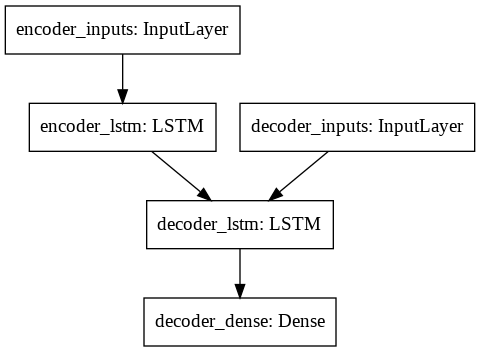

In [23]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png',height=400,width=400)

# The Model architecture is explined in the diagram above 

# Test-5

<ol>
<li> Step 1: Use a LSTM encoder to get input words encoded in the form of (encoder outputs, encoder hidden state, encoder context) from input words
<li> Step 2:  Use a LSTM decoder to get target words encoded in the form of (decoder outputs, decoder hidden state, decoder context) from target words. Use encoder hidden states and encoder context (represents input memory) as initial state .
<li> Step 3: Use a dense layer to predict the next token out of the vocabulary given decoder output generated by Step 2.
<li> Step 4: Use loss ='categorical_crossentropy' and optimizer='rmsprop'
</ol>

In [22]:
'''write your code here.
   create a model object'''
encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
encoder_states = [encoder_state_h, encoder_state_c]

decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                 initial_state=encoder_states)
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')


# Check-5 

Check the model summary should look like this 

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 100)    0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, None, 100)    0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 365568      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  365568      decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]         

# Prediction

In [0]:
train_gen = generate_batch(Xtrain, Ytrain)
test_gen = generate_batch(Xtest, Ytest)

train_num_batches = len(Xtrain) // BATCH_SIZE
test_num_batches = len(Xtest) // BATCH_SIZE

checkpoint = ModelCheckpoint(filepath=WEIGHT_FILE_PATH, save_best_only=True)
model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                    epochs=NUM_EPOCHS,verbose=1, 
                    validation_data=test_gen, 
                    validation_steps=test_num_batches, callbacks=[checkpoint])

model.save_weights(WEIGHT_FILE_PATH)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





3805/3805 [==============================] - 1055s 277ms/step - loss: 1.4368 - val_loss: 1.3710
Epoch 2/50
3805/3805 [==============================] - 1037s 272ms/step - loss: 1.3440 - val_loss: 1.3489
Epoch 3/50
3805/3805 [==============================] - 1034s 272ms/step - loss: 1.3267 - val_loss: 1.3403
Epoch 4/50
3805/3805 [==============================] - 1034s 272ms/step - loss: 1.3218 - val_loss: 1.3414
Epoch 5/50
3805/3805 [==============================] - 1034s 272ms/step - loss: 1.3186 - val_loss: 1.3417
Epoch 6/50
3805/3805 [==============================] - 1031s 271ms/step - loss: 1.3176 - val_loss: 1.3448
Epoch 7/50
3805/3805 [==============================] - 1035s 272ms/step - loss: 1.3214 - val_loss: 1.3520
Epoch 8/50
3805/3805 [==============================] - 1033s 271ms/step - loss: 1.3234 - val_loss: 1.3531
Epoch 9/50
3805/3805 [====================

In [25]:
from keras.models import Model, model_from_json
class RikiChatBot(object):
    model = None
    encoder_model = None
    decoder_model = None
    target_word2idx = None
    target_idx2word = None
    max_decoder_seq_length = None
    max_encoder_seq_length = None
    num_decoder_tokens = None
    word2em = None
    def __init__(self):
        self.word2em = word2embedding
        self.target_word2idx = np.load(
            '/content/gdrive/My Drive/Conversational Chatbot/word-glove-target-idx2word.npy',allow_pickle=True).item()
        self.target_idx2word = np.load(
            '/content/gdrive/My Drive/Conversational Chatbot/word-glove-target-idx2word.npy',allow_pickle=True).item()
        context = np.load('/content/gdrive/My Drive/Conversational Chatbot/word-glove-context.npy',allow_pickle=True).item()
        self.max_encoder_seq_length = context['encoder_max_seq_length']
        self.max_decoder_seq_length = context['decoder_max_seq_length']
        self.num_decoder_tokens = context['num_decoder_tokens']
        encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
        encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name="encoder_lstm")
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
        decoder_lstm = LSTM(units=HIDDEN_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model_json = open('/content/gdrive/My Drive/Conversational Chatbot/word-glove-architecture.json', 'r').read()
        self.model = model_from_json(model_json)
        self.model.load_weights('/content/gdrive/My Drive/Conversational Chatbot/word-glove-weights.h5')
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

        self.encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)


    def reply(self, input_text):
        input_seq = []
        input_emb = []
        for word in nltk.word_tokenize(input_text.lower()):
            if not in_white_list(word):
                continue
            emb = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
            if word in self.word2em:
                emb = self.word2em[word]
            input_emb.append(emb)
        input_seq.append(input_emb)
        input_seq = pad_sequences(input_seq, self.max_encoder_seq_length)
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
        target_seq[0, 0, :] = self.word2em['start']
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)
            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1
            if sample_word != 'start' and sample_word != 'end':
                target_text += ' ' + sample_word
            if sample_word == 'end' or target_text_len >= self.max_decoder_seq_length:
                terminated = True
            target_seq = np.zeros((1, 1, GLOVE_EMBEDDING_SIZE))
            if sample_word in self.word2em:
                target_seq[0, 0, :] = self.word2em[sample_word]
            states_value = [h, c]
        return target_text.strip()
    def test_run(self):
        print(self.reply("Hello"))
        print(self.reply("Is it sunny day ?"))

def main():
    model = RikiChatBot()
    model.test_run()

if __name__ == '__main__':
    main()







vicki geordi watches watches types lest lest correct vicki watches lest lest correct vicki watches lest lest correct correct vicki watches watches lest lest correct vicki fin geordi watches watches doctor fridge misunderstanding fin studying cut vicki luck luck luck luck tension
vicki geordi watches applejack g-d g-d spook younger g-d g-d spook younger g-d cut vicki g-d spook fin tracks occasions occasions dine endure outpost corner corner rolling want want vicki orange luck luck tension luck luck luck killing killing killing probably luck
